<h1>Polynomial Regression Model</h1>
<p>Models generated using Sklearn. Datasets gathered from <a href = "https://www.coindesk.com/">CoinDesk<a></p>

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math as ma
from IPython import get_ipython

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import operator

get_ipython().run_line_magic('matplotlib', 'inline')

# ['#f39506', '#115268', '#FDB6BA', '#BC8E8E', '#4682B4', '#8486BF']

In [209]:
def days_prior(df: pd.DataFrame, days: int, time_frame: int = 0) -> pd.DataFrame:

    epoch = len(df.index) - ma.floor(days)

    if time_frame == 0.0:

        return df[(df.index >= epoch)]

    else:
        
        end = epoch + ma.floor(time_frame)

        return df[(df.index >= epoch) & (df.index < end)]

    
def train_test_split_by_date(df: pd.DataFrame, x: str, y: str, reverse_epoch: int, time_interval: int = None):
    
    '''
        returns a list of x_train, y_train, x_test, y_test, x_full, y_full in order
    '''

    if(time_interval == None or time_interval == 0.0):
        
        time_interval = reverse_epoch - 1

    df_full  = days_prior(df, reverse_epoch, time_interval + 1)
    df_train = days_prior(df, reverse_epoch, time_interval)
    df_test  = days_prior(df, reverse_epoch - time_interval, 1)

    if x == 'index':
        x_full  = df_full.index.to_numpy()
        y_full  = df_full[y].to_numpy()
        x_train = df_train.index.to_numpy()
        x_test  = df_test.index.to_numpy()
        y_train = df_train[y].to_numpy()
        y_test  = df_test[y].to_numpy()

    else:
        x_full  = df_full[x].to_numpy()
        y_full  = df_full[y].to_numpy()
        x_train = df_train[x].to_numpy()
        x_test  = df_test[x].to_numpy()
        y_train = df_train[y].to_numpy()
        y_test  = df_test[y].to_numpy()

    return [x_train, y_train, x_test, y_test, x_full, y_full]


def polynomial_regression_model_predict(df: pd.DataFrame, degree: int, epoch: int, period: float = None, name: str = 'df', color: list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']) -> dict:

    x_train, y_train, x_test, y_test, x_full, y_full = train_test_split_by_date(df, 'index', 'price', epoch, period)

    polynomial_features = PolynomialFeatures(degree = degree)
    x_poly_train = polynomial_features.fit_transform(x_train[:, None])

    model = LinearRegression()
    model.fit(x_poly_train, y_train)

    y_pred_test = model.predict(polynomial_features.fit_transform(x_test[:, None]))
    y_pred_full = model.predict(polynomial_features.fit_transform(x_full[:, None]))

    plt.figure(figsize = (30,10))
    plt.title(name)
    plt.grid(False)

    
    plt.scatter(df['date'][ x_test[0] : x_test[-1] + 1], y_test, label = 'Tested value', color = color[0])
    plt.scatter(df['date'][ x_test[0] : x_test[-1] + 1], y_pred_test, label = 'Predicted value', color = color[1])

    plt.plot(df['date'][ x_full[0] : x_full[-1] + 1], y_full, label = 'Full data', color = color[2])
    plt.plot(df['date'][ x_train[0] : x_train[-1] + 1], y_train, label = 'Train data', color = color[3])

    sorted_zip = sorted(zip(x_full, y_pred_full), key = operator.itemgetter(0))
    x_full, y_pred_full = zip(*sorted_zip)

    plt.plot(df['date'][ x_full[0] : x_full[-1] + 1], y_pred_full, label = 'Prediction curve', color = color[4])

    plt.legend(loc = 'best')
    plt.show()

    return {'accuracy': abs(y_pred_test - y_test), 'rmse': np.sqrt(mean_squared_error(y_full, y_pred_full)), 'r2': r2_score(y_full, y_pred_full)}

In [210]:
def get_csv(path: str) -> pd.DataFrame:
    
    df = pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price'})

    return df

In [211]:
df_ada = get_csv('./data/Cardano.csv')
df_eth = get_csv('./data/ethereum.csv')
df_sol = get_csv('./data/solana.csv')
df_doge = get_csv('./data/dogecoin.csv')

In [337]:
def rolling_forecast(df: pd.DataFrame, degree = 1, time_window = 30, test_ratio: float = 0.3) -> pd.DataFrame:

    prediction_roll = pd.Series(dtype = 'float64')
    test_data = df[ma.floor(len(df.index) * (1 - test_ratio)) + 1:]

    for end_date in test_data.index:
        train_data = df[end_date - time_window:end_date - 1]

        polynomial_features = PolynomialFeatures(degree = degree)
        model = LinearRegression()
        model.fit(polynomial_features.fit_transform(train_data.index.to_numpy()[:, None]), train_data[['price']].to_numpy())
        pred: np.ndarray = model.predict(polynomial_features.fit_transform([[end_date]]))

        prediction_roll.loc[end_date] = pred[0][0]

    return pd.DataFrame({'pred': prediction_roll, 'real': test_data['price']}).set_index(test_data['date'])


def mean_absolute_percentage_error(rolling_forecast_result: pd.DataFrame) -> float:
    
    return round(np.mean(abs(1 - (rolling_forecast_result['pred'] / rolling_forecast_result['real']))) * 100, 2) 

In [338]:
eth_rolling_3_1 = rolling_forecast(df_eth, 1, 3)
eth_rolling_7_1 = rolling_forecast(df_eth, 1, 7)
eth_rolling_10_1 = rolling_forecast(df_eth, 1, 10)
eth_rolling_14_1 = rolling_forecast(df_eth, 1, 14)
eth_rolling_21_1 = rolling_forecast(df_eth, 1, 21)
eth_rolling_30_2 = rolling_forecast(df_eth, 1, 30)

9.55
6.82
6.89
7.3
7.96
8.99


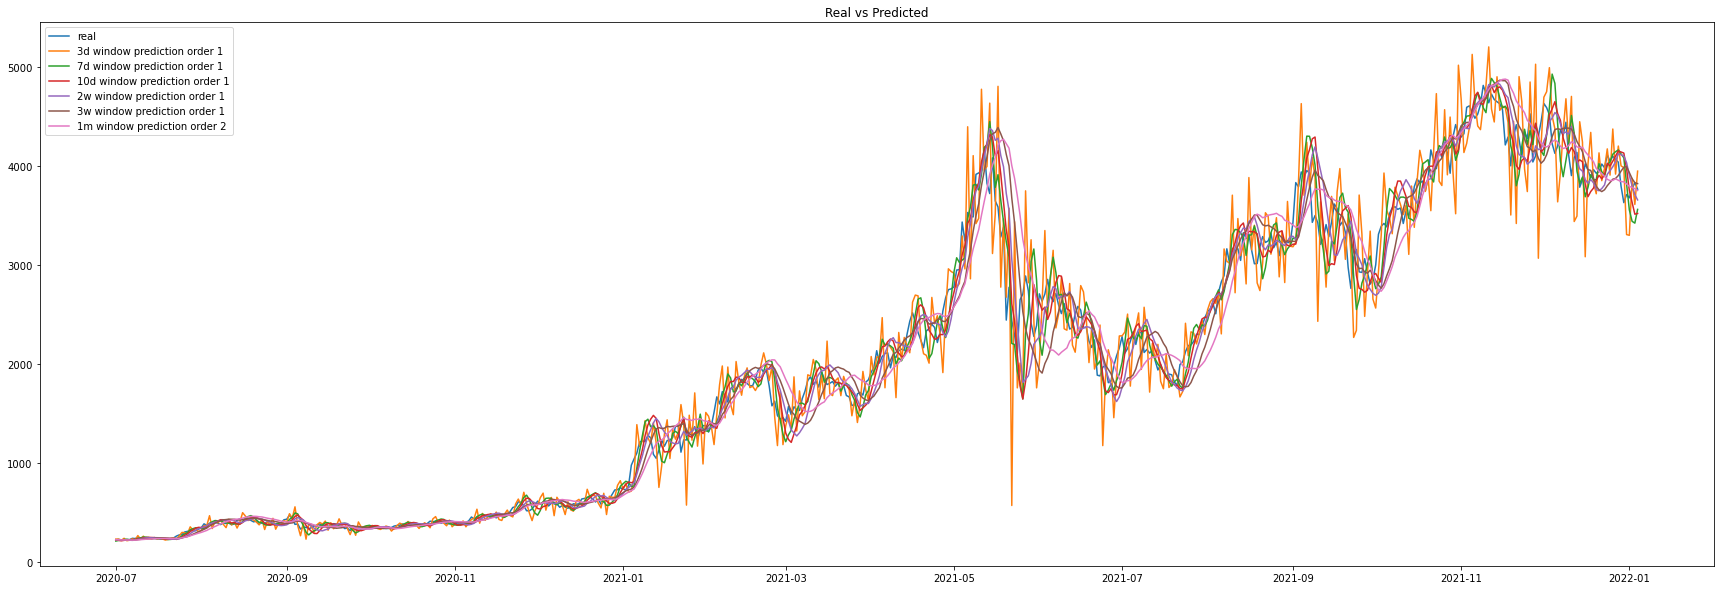

In [340]:
plt.figure(figsize = (30,10))
plt.title('Real vs Predicted')

plt.plot(eth_rolling_7_1[['real']], label = 'real')
plt.plot(eth_rolling_3_1[['pred']], label = '3d window prediction order 1')
plt.plot(eth_rolling_7_1[['pred']], label = '7d window prediction order 1')
plt.plot(eth_rolling_10_1[['pred']], label = '10d window prediction order 1')
plt.plot(eth_rolling_14_1[['pred']], label = '2w window prediction order 1')
plt.plot(eth_rolling_21_1[['pred']], label = '3w window prediction order 1')
plt.plot(eth_rolling_30_2[['pred']], label = '1m window prediction order 2')

print(mean_absolute_percentage_error(eth_rolling_3_1))
print(mean_absolute_percentage_error(eth_rolling_7_1))
print(mean_absolute_percentage_error(eth_rolling_10_1))
print(mean_absolute_percentage_error(eth_rolling_14_1))
print(mean_absolute_percentage_error(eth_rolling_21_1))
print(mean_absolute_percentage_error(eth_rolling_30_2))

plt.legend(loc = 'best')
plt.show()

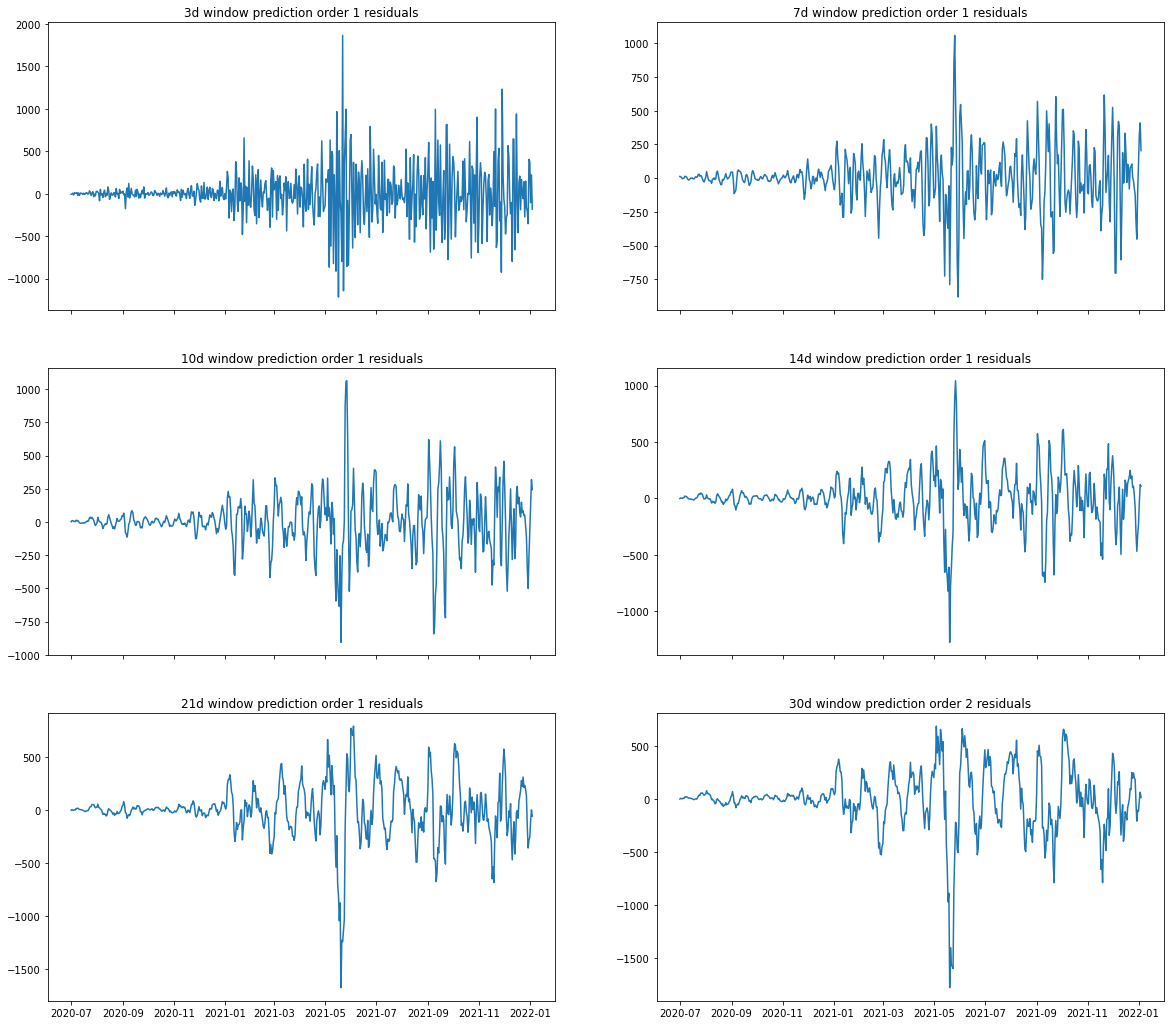

In [346]:
eth_rolling_3_1_residuals = eth_rolling_3_1['real'] - eth_rolling_3_1['pred']
eth_rolling_7_1_residuals = eth_rolling_7_1['real'] - eth_rolling_7_1['pred']
eth_rolling_10_1_residuals = eth_rolling_10_1['real'] - eth_rolling_10_1['pred']
eth_rolling_14_1_residuals = eth_rolling_14_1['real'] - eth_rolling_14_1['pred']
eth_rolling_21_1_residuals = eth_rolling_21_1['real'] - eth_rolling_21_1['pred']
eth_rolling_30_2_residuals = eth_rolling_30_2['real'] - eth_rolling_30_2['pred']


fig, axes = plt.subplots(3, 2, sharex = 'all', figsize = (20, 18))
axes[0, 0].plot(eth_rolling_3_1_residuals)
axes[0, 1].plot(eth_rolling_7_1_residuals)
axes[1, 0].plot(eth_rolling_10_1_residuals)
axes[1, 1].plot(eth_rolling_14_1_residuals)
axes[2, 0].plot(eth_rolling_21_1_residuals)
axes[2, 1].plot(eth_rolling_30_2_residuals)

axes[0, 0].set_title('3d window prediction order 1 residuals')
axes[0, 1].set_title('7d window prediction order 1 residuals')
axes[1, 0].set_title('10d window prediction order 1 residuals')
axes[1, 1].set_title('14d window prediction order 1 residuals')
axes[2, 0].set_title('21d window prediction order 1 residuals')
axes[2, 1].set_title('30d window prediction order 2 residuals')

plt.show()